In [201]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import random
from tqdm import tqdm 
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os



In [202]:
df=pd.read_csv('full_df.csv')

In [203]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


### Extracting Cataract and Normal Information from the dataset


In [204]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [205]:
df["left_cataract"]=df["Left-Diagnostic Keywords"].apply(lambda x:has_cataract(x))
df["right_cataract"]=df["Right-Diagnostic Keywords"].apply(lambda x:has_cataract(x))

In [206]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [207]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [208]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [209]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [210]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [211]:
print(len(cataract),len(normal))

594 500


### Creating dataset from images

In [212]:
from tensorflow.keras.utils import load_img
dataset_dir='preprocessed_images/'
image_size=224
labels=[]
dataset=[]
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path=os.path.join(dataset_dir,img)
        try:
            image=cv2.imread(image_path,cv2.IMREAD_COLOR)
            image=cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    
    random.shuffle(dataset)
    return dataset
            
            


In [213]:
dataset=create_dataset(cataract,1)
len(dataset)

100%|██████████| 594/594 [00:01<00:00, 347.55it/s]


588

In [214]:
dataset=create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:01<00:00, 325.33it/s]


1088

### Creating a physical database from the memory one

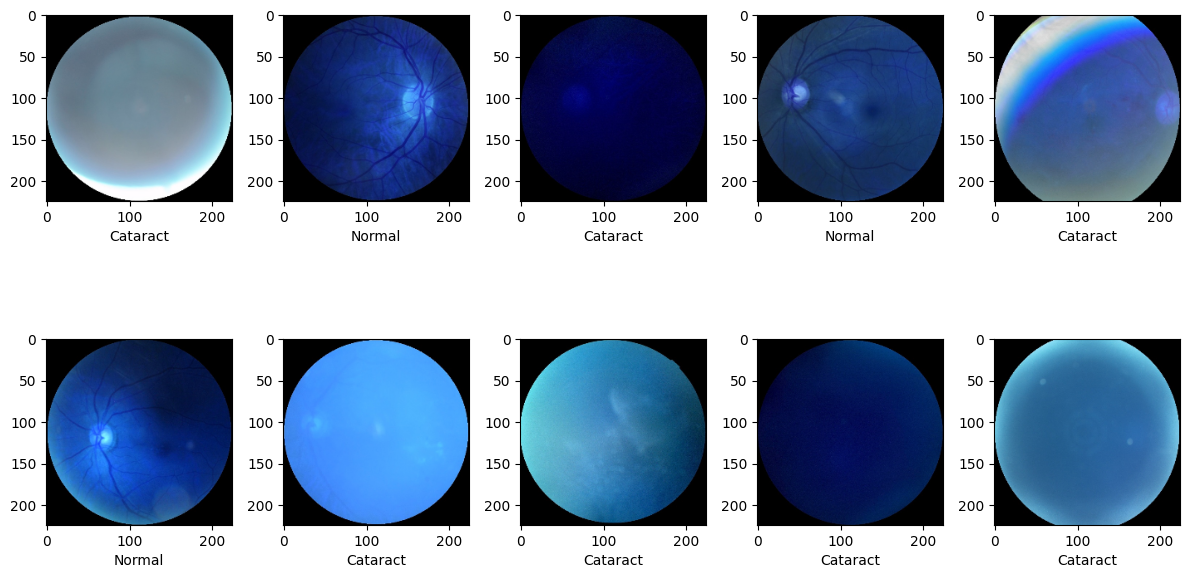

In [215]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 
  

In [216]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [217]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [218]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [219]:
MobileNet=MobileNetV3Large(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


In [220]:
for layer in MobileNet.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

In [221]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout

In [222]:
# Add additional layers for classification
x = MobileNet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # 'num_classes' is the number of classes in your dataset


In [223]:
# Create the final model
model = tf.keras.Model(inputs=MobileNet.input, outputs=predictions)

In [224]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_6[0][0]']            
                                )                                                                 
                                                                                            

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 56, 56, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_239 (ReLU)               (None, 56, 56, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 56, 56, 24)  1728        ['re_lu_239[0][0]']              
 D)                                                                                               
                                                                                                  
 expanded_

 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_244 (ReLU)               (None, 28, 28, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_244[0][0]']              
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Co

                                                                                                  
 expanded_conv_5/project (Conv2  (None, 28, 28, 40)  4800        ['expanded_conv_5/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, 28, 28, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 28, 28, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
          

 tf.__operators__.add_175 (TFOp  (None, 14, 14, 200)  0          ['expanded_conv_7/depthwise/Batch
 Lambda)                                                         Norm[0][0]']                     
                                                                                                  
 re_lu_252 (ReLU)               (None, 14, 14, 200)  0           ['tf.__operators__.add_175[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_175 (TFOpLamb  (None, 14, 14, 200)  0          ['re_lu_252[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_124 (Multiply)        (None, 14, 14, 200)  0           ['expanded_conv_7/depthwise/Batch
          

                                                                                                  
 tf.math.multiply_178 (TFOpLamb  (None, 14, 14, 184)  0          ['re_lu_255[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_127 (Multiply)        (None, 14, 14, 184)  0           ['expanded_conv_9/expand/BatchNor
                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_178[0][0]']   
                                                                                                  
 expanded_conv_9/depthwise (Dep  (None, 14, 14, 184)  1656       ['multiply_127[0][0]']           
 thwiseConv2D)                                                                                    
          

 e/Relu (ReLU)                                                   /Conv[0][0]']                    
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 1, 1, 480)   58080       ['expanded_conv_10/squeeze_excite
 e/Conv_1 (Conv2D)                                               /Relu[0][0]']                    
                                                                                                  
 tf.__operators__.add_182 (TFOp  (None, 1, 1, 480)   0           ['expanded_conv_10/squeeze_excite
 Lambda)                                                         /Conv_1[0][0]']                  
                                                                                                  
 re_lu_259 (ReLU)               (None, 1, 1, 480)    0           ['tf.__operators__.add_182[0][0]'
                                                                 ]                                
          

 expanded_conv_11/squeeze_excit  (None, 14, 14, 672)  0          ['multiply_132[0][0]',           
 e/Mul (Multiply)                                                 'tf.math.multiply_185[0][0]']   
                                                                                                  
 expanded_conv_11/project (Conv  (None, 14, 14, 112)  75264      ['expanded_conv_11/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_11/project/Batch  (None, 14, 14, 112)  448        ['expanded_conv_11/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/Add (Add)     (None, 14, 14, 112)  0           ['expanded_conv_10/project/BatchN
          

 expanded_conv_12/project/Batch  (None, 7, 7, 160)   640         ['expanded_conv_12/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_13/expand (Conv2  (None, 7, 7, 960)   153600      ['expanded_conv_12/project/BatchN
 D)                                                              orm[0][0]']                      
                                                                                                  
 expanded_conv_13/expand/BatchN  (None, 7, 7, 960)   3840        ['expanded_conv_13/expand[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 tf.__operators__.add_189 (TFOp  (None, 7, 7, 960)   0           ['expanded_conv_13/expand/BatchNo
 Lambda)  

 tf.__operators__.add_192 (TFOp  (None, 7, 7, 960)   0           ['expanded_conv_14/expand/BatchNo
 Lambda)                                                         rm[0][0]']                       
                                                                                                  
 re_lu_269 (ReLU)               (None, 7, 7, 960)    0           ['tf.__operators__.add_192[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_192 (TFOpLamb  (None, 7, 7, 960)   0           ['re_lu_269[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_137 (Multiply)        (None, 7, 7, 960)    0           ['expanded_conv_14/expand/BatchNo
          

                                                                                                  
 global_average_pooling2d_8 (Gl  (None, 960)         0           ['multiply_139[0][0]']           
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_13 (Dense)               (None, 512)          492032      ['global_average_pooling2d_8[0][0
                                                                 ]']                              
                                                                                                  
 dropout_6 (Dropout)            (None, 512)          0           ['dense_13[0][0]']               
                                                                                                  
 dense_14 (Dense)               (None, 1)            513         ['dropout_6[0][0]']              
          

In [225]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [226]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [227]:
checkpoint=ModelCheckpoint('mobilenet.h5',monitor="val_accuracy",verbose=1,save_best_only=True,save_weights_only=False,save_freq=1)

In [228]:
earlystop=EarlyStopping(monitor='val_accuracy',patience=5,verbose=1)

In [229]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - 9s 142ms/step - loss: 0.2412 - accuracy: 0.9103 - val_loss: 2.5313 - val_accuracy: 0.5229
Epoch 2/15
21/28 [=====================>........] - ETA: 0s - loss: 0.0814 - accuracy: 0.9717WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/28 [==============================] - 3s 106ms/step - loss: 0.0766 - accuracy: 0.9747 - val_loss: 5.0585 - val_accuracy: 0.5275
Epoch 3/15
28/28 [==============================] - 3s 107ms/step - loss: 0.0321 - accuracy: 0.9931 - val_loss: 6.8262 - val_accuracy: 0.5734
Epoch 4/15
14/28 [==============>...............] - ETA: 1s - loss: 0.0713 - accuracy: 0.9732WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/28 [==============================] - 3s 106ms/step - loss: 0.0541 - accuracy: 0.9793 - val_loss: 7.5201 - val_accuracy: 0.7018
Epoch 5/15
28/28 [==============================] - 3s 106ms/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 10.6936 - val_accuracy: 0.6697
Epoch 6/15
 7/28 [======>.......................] - ETA: 2s - loss: 0.0347 - accuracy: 0.9821WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.


28/28 [==============================] - 3s 105ms/step - loss: 0.0325 - accuracy: 0.9885 - val_loss: 8.4803 - val_accuracy: 0.5963
Epoch 7/15
22/28 [======================>.......] - ETA: 0s - loss: 0.0048 - accuracy: 0.9986

KeyboardInterrupt: 

In [232]:
print(x_train.shape)

(870, 224, 224, 3)


In [233]:
print(x_test.shape)

(218, 224, 224, 3)


In [234]:
print(y_train.shape)

(870,)


In [235]:
print(y_test.shape)

(218,)
